# Melhor modelo LSTM padrao ate o momento R2 de .71

In [32]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sympy import false
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from copy import deepcopy as dc
import logging
from datetime import datetime
import optuna
import torch.nn.functional as F
import os

In [33]:
# Configuração inicial
data_hoje = datetime.now().strftime('%d-%m')
inicio_execucao = pd.Timestamp.now()

# Criando diretórios para logs e plots
os.makedirs(f'../logs/{data_hoje}', exist_ok=True)
os.makedirs(f'../plots/{data_hoje}', exist_ok=True)

# Configuração do logging
logging.basicConfig(filename=f'../logs/{data_hoje}/lstm_optuna.log', level=logging.INFO, format='- %(message)s')
logging.info('-' * 50)
logging.info(f'{inicio_execucao} - Iniciando o processo de otimização e treinamento do modelo LSTM')

# Carregando e preparando os dados
df_original = pd.read_csv('../dados_tratados/combinado/Piratininga/Piratininga_tratado_combinado.csv',
                          usecols=['PM2.5', 'Data e Hora', 'PM10', 'Monóxido de Carbono', 'Dióxido de Enxofre',
                                   'Dióxido de Nitrogênio', 'Temperatura', 'Velocidade do Vento'], low_memory=False)

df_original['Data e Hora'] = pd.to_datetime(df_original['Data e Hora'])
df_original.set_index('Data e Hora', inplace=True)
df_original.sort_index(inplace=True)

colunas_selecionadas = ['PM2.5', 'PM10', 'Monóxido de Carbono']
logging.info(f"Colunas selecionadas: {colunas_selecionadas}")
df = df_original[colunas_selecionadas]
df = df.loc['2019-01-01':'2022-01-01']

df = df.apply(pd.to_numeric, errors='coerce')

In [34]:
# fazendo o logging de qual algoritmo de imputação foi utilizado
def log_imputation(method_name, impute_function, df):
    df_imputed = impute_function(df)
    logging.info(f"Imputação realizada usando: {method_name}")
    return df_imputed

def linear_interpolation_imputer(df):
    df_imputed = df.interpolate(method='linear')
    return df_imputed

df_imputed = log_imputation('Linear Interpolation', linear_interpolation_imputer, df)

logging.info(f"Dados ausentes antes da imputação: {df.isna().sum()}")
logging.info(f"Dados ausentes após a imputação: {df_imputed.isna().sum()}")
logging.info(f"Dados totais: {len(df_imputed)}")

In [35]:
import numpy as np
import pandas as pd
from scipy import stats

def z_score_method(df, threshold=3):
    """
    Remove outliers based on Z-score method.
    """
    z_scores = np.abs(stats.zscore(df))
    df_clean = df[(z_scores < threshold).all(axis=1)]
    return df_clean

def iqr_method(df, factor=1.5):
    """
    Remove outliers based on Interquartile Range (IQR) method.
    """
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_clean = df[~((df < (Q1 - factor * IQR)) | (df > (Q3 + factor * IQR))).any(axis=1)]
    return df_clean

def winsorization(df, limits=(0.05, 0.05)):
    """
    Apply winsorization to cap extreme values.
    """
    return df.apply(lambda x: stats.mstats.winsorize(x, limits=limits))

def moving_average_smoothing(df, window=5):
    """
    Apply moving average smoothing to reduce the impact of outliers.
    """
    return df.rolling(window=window, center=True).mean()

def treat_outliers(df, method='z_score', **kwargs):
    """
    Apply the specified outlier treatment method.
    """
    if method == 'z_score':
        return z_score_method(df, **kwargs)
    elif method == 'iqr':
        return iqr_method(df, **kwargs)
    elif method == 'winsorization':
        return winsorization(df, **kwargs)
    elif method == 'moving_average':
        return moving_average_smoothing(df, **kwargs)
    else:
        raise ValueError("Invalid outlier treatment method")

# After loading and before scaling the data
outlier_method = 'winsorization'  # Choose the method: 'z_score', 'iqr', 'winsorization', or 'moving_average'
df_imputed = treat_outliers(df_imputed, method=outlier_method)

logging.info(f"Outlier treatment applied using {outlier_method} method")
logging.info(f"Data shape after outlier treatment: {df_imputed.shape}")


In [36]:
# Preparando os dados para LSTM
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for col in colunas_selecionadas:
        for i in range(1, n_steps + 1):
            df[f'{col}(t-{i})'] = df[col].shift(i)
    df.dropna(inplace=True)
    return df


lookback = 8
shifted_df = prepare_dataframe_for_lstm(df_imputed, lookback)

# Dividindo em conjuntos de treino, validação e teste
train_size = int(len(shifted_df) * 0.7)
val_size = int(len(shifted_df) * 0.15)

train_df = shifted_df.iloc[:train_size]
val_df = shifted_df.iloc[train_size:train_size + val_size]
test_df = shifted_df.iloc[train_size + val_size:]

# Normalizando os dados de forma correta
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=shifted_df.columns, index=train_df.index)
val_scaled = pd.DataFrame(scaler.transform(val_df), columns=shifted_df.columns, index=val_df.index)
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=shifted_df.columns, index=test_df.index)

X_train, y_train = train_scaled.iloc[:, len(colunas_selecionadas):].values, train_scaled.iloc[:, 0].values
X_val, y_val = val_scaled.iloc[:, len(colunas_selecionadas):].values, val_scaled.iloc[:, 0].values
X_test, y_test = test_scaled.iloc[:, len(colunas_selecionadas):].values, test_scaled.iloc[:, 0].values

# Reshape para LSTM
X_train = X_train.reshape((-1, lookback, len(colunas_selecionadas)))
X_val = X_val.reshape((-1, lookback, len(colunas_selecionadas)))
X_test = X_test.reshape((-1, lookback, len(colunas_selecionadas)))
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

# Convertendo para tensores PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Dataset e DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


# Modelo LSTM
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(hidden_size))

    def forward(self, lstm_output):
        attention_scores = torch.tanh(torch.matmul(lstm_output, self.attention_weights))
        attention_scores = F.softmax(attention_scores, dim=1)
        weighted_output = torch.mul(lstm_output, attention_scores.unsqueeze(-1))
        return weighted_output.sum(dim=1)


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation, dropout):
        super().__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.activation = activation

        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size if i == 0 else hidden_sizes[i - 1],
                    hidden_sizes[i],
                    num_layers=1,
                    batch_first=True)
            for i in range(len(hidden_sizes))
        ])

        self.attention = Attention(hidden_sizes[-1])
        self.dropout = nn.Dropout(dropout) if self.num_layers > 1 else nn.Identity()
        self.fc = nn.Linear(hidden_sizes[-1], 1)

    def forward(self, x):
        batch_size = x.size(0)
        for i, lstm in enumerate(self.lstm_layers):
            h0 = torch.zeros(1, batch_size, self.hidden_sizes[i]).to(x.device)
            c0 = torch.zeros(1, batch_size, self.hidden_sizes[i]).to(x.device)
            x, _ = lstm(x, (h0, c0))

            if i < len(self.lstm_layers) - 1:
                x = self.apply_activation(x)
                x = self.dropout(x)

        # Aplicar mecanismo de atenção
        x = self.attention(x)
        out = self.fc(x)
        return out

    def apply_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'tanh':
            return F.tanh(x)
        elif self.activation == 'sigmoid':
            return F.sigmoid(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x)
        elif self.activation == 'elu':
            return F.elu(x)
        else:
            return x


In [38]:
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Função de treinamento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()

            # Gradient clipping
            clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)
                val_loss += criterion(output, y_batch).item()
        val_loss /= len(val_loader)

        # Ajuste da taxa de aprendizagem
        scheduler.step(val_loss)

        # logging.info(f"Época {epoch + 1}/{num_epochs}, Perda de treino: {train_loss:.4f}, Perda de validação: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            logging.info(f"Early stopping ativado na época {epoch + 1}")
            break

    # Carregar o melhor modelo
    model.load_state_dict(best_model_state)
    return model

In [39]:
def objective(trial):
    # Hiperparâmetros para otimização
    num_layers = trial.suggest_int('num_layers', 1, 4)
    hidden_sizes = [trial.suggest_int(f'hidden_size_{i}', 8, 128) for i in range(num_layers)]
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'leaky_relu', 'elu'])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)

    # Criação dos DataLoaders
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset = TimeSeriesDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Criação e treinamento do modelo
    model = LSTM(len(colunas_selecionadas), hidden_sizes, activation, dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.HuberLoss()

    num_epochs = 100
    early_stopping_patience = 10

    model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopping_patience,
                        device)

    # Avaliação no conjunto de validação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            val_loss += criterion(output, y_batch).item()
    val_loss /= len(val_loader)

    return val_loss


In [40]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=2)

best_params = study.best_params
logging.info(f"Melhores hiperparâmetros: {best_params}")

# Treinamento final com os melhores hiperparâmetros
best_hidden_sizes = [best_params[f'hidden_size_{i}'] for i in range(best_params['num_layers'])]
best_batch_size = best_params['batch_size']

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

final_model = LSTM(len(colunas_selecionadas), best_hidden_sizes, best_params['activation'], best_params['dropout']).to(
    device)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['learning_rate'],
                              weight_decay=best_params['weight_decay'])
criterion = nn.HuberLoss()

num_epochs = 100
patience = 10

final_model = train_model(final_model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, device)

# Salvar o modelo final
torch.save(final_model.state_dict(), f'../models/best_model_optuna_{data_hoje}.pth')


# Avaliação final
def evaluate(model, dataloader):
    predictions = []
    actual = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            predictions.extend(output.cpu().numpy().flatten())
            actual.extend(y_batch.cpu().numpy().flatten())
    return np.array(predictions), np.array(actual)


train_predictions, train_actual = evaluate(final_model, train_loader)
val_predictions, val_actual = evaluate(final_model, val_loader)
test_predictions, test_actual = evaluate(final_model, test_loader)

[I 2024-09-02 17:42:49,754] A new study created in memory with name: no-name-e5735a89-ac46-4cf1-8369-de94c8ef79c1
C:\dev\scripts\pm25-plots\venv\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[I 2024-09-02 17:46:41,831] Trial 0 finished with value: 0.02119579561986029 and parameters: {'num_layers': 4, 'hidden_size_0': 52, 'hidden_size_1': 26, 'hidden_size_2': 64, 'hidden_size_3': 56, 'batch_size': 512, 'learning_rate': 1.9517145801657e-05, 'activation': 'relu', 'dropout': 0.4061610610227259, 'weight_decay': 0.006753804842089562}. Best is trial 0 with value: 0.02119579561986029.
[I 2024-09-02 17:53:06,776] Trial 1 finished with value: 0.014494375870262663 and parameters: {'num_layers': 2, 'hidden_size_0': 76, 'hidden_size_1': 113, 'batch_size': 64, 'learning_rate': 0.00036478563000998294, 'activation': 'elu', 'dropout': 0.44014552327964057, 'weight_decay': 0.006901

In [41]:
# Desnormalização
def inverse_transform_data(normalized_data):
    # Criar um array de zeros com o mesmo número de colunas que os dados originais
    dummy_array = np.zeros((len(normalized_data), len(shifted_df.columns)))

    # Colocar os dados normalizados na primeira coluna (assumindo que é PM2.5)
    dummy_array[:, 0] = normalized_data

    # Aplicar a transformação inversa
    denormalized_data = scaler.inverse_transform(dummy_array)

    # Retornar apenas a primeira coluna, que contém os dados desnormalizados de interesse
    return denormalized_data[:, 0]


# Desnormalização das previsões e valores reais
train_predictions = inverse_transform_data(train_predictions)
val_predictions = inverse_transform_data(val_predictions)
test_predictions = inverse_transform_data(test_predictions)

# Para os valores reais, precisamos garantir que estamos usando os dados originais não normalizados
train_actual = df_imputed['PM2.5'].values[:len(train_predictions)]
val_actual = df_imputed['PM2.5'].values[len(train_predictions):len(train_predictions) + len(val_predictions)]
test_actual = df_imputed['PM2.5'].values[-len(test_predictions):]


# Cálculo das métricas
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mse, mae, r2, mape


# Calcular métricas
train_rmse, train_mse, train_mae, train_r2, train_mape = calculate_metrics(train_actual, train_predictions)
val_rmse, val_mse, val_mae, val_r2, val_mape = calculate_metrics(val_actual, val_predictions)
test_rmse, test_mse, test_mae, test_r2, test_mape = calculate_metrics(test_actual, test_predictions)

# Logging dos resultados
logging.info(
    f"Métricas de Treino: RMSE={train_rmse:.4f}, MSE={train_mse:.4f}, MAE={train_mae:.4f}, R2={train_r2:.4f}, MAPE={train_mape:.4f}")
logging.info(
    f"Métricas de Validação: RMSE={val_rmse:.4f}, MSE={val_mse:.4f}, MAE={val_mae:.4f}, R2={val_r2:.4f}, MAPE={val_mape:.4f}")
logging.info(
    f"Métricas de Teste: RMSE={test_rmse:.4f}, MSE={test_mse:.4f}, MAE={test_mae:.4f}, R2={test_r2:.4f}, MAPE={test_mape:.4f}")

print(
    f"Métricas de Treino: RMSE={test_rmse:.4f}, MSE={test_mse:.4f}, MAE={test_mae:.4f}, R2={test_r2:.4f}, MAPE={test_mape:.4f}")

Métricas de Treino: RMSE=3.4257, MSE=11.7351, MAE=2.4343, R2=0.7415, MAPE=34.1955


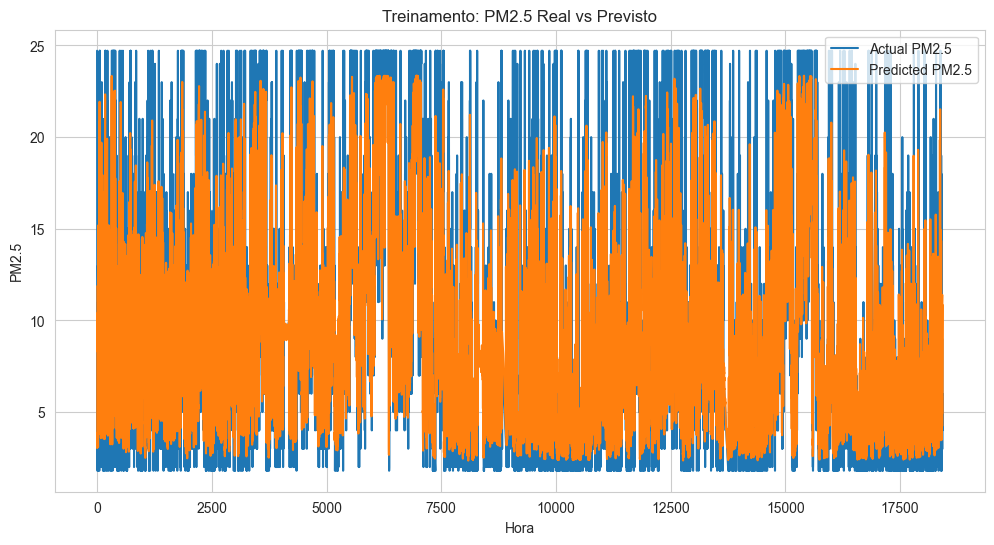

In [42]:

# Log das métricas finais
logging.info("\nMétricas finais:")
logging.info("Treinamento - RMSE: {:.4f}, MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(train_rmse, train_mse, train_mae,
                                                                                       train_r2))
logging.info(
    "Validação - RMSE: {:.4f}, MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(val_rmse, val_mse, val_mae, val_r2))
logging.info(
    "Teste - RMSE: {:.4f}, MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(test_rmse, test_mse, test_mae, test_r2))

# Plotagem dos resultados
plt.figure(figsize=(12, 6))
plt.plot(train_actual, label='Actual PM2.5')
plt.plot(train_predictions, label='Predicted PM2.5')
plt.title('Treinamento: PM2.5 Real vs Previsto')
plt.xlabel('Hora')
plt.ylabel('PM2.5')
plt.legend()
plt.savefig(f'../plots/{data_hoje}/lstm_optuna_train_{data_hoje}.png')


In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

train_dates = shifted_df.index[:len(train_actual)]
val_dates = shifted_df.index[len(train_actual):len(train_actual) + len(val_actual)]
test_dates = shifted_df.index[-len(test_actual):]


def plot_results(actual, predicted, dates, title, filename):
    plt.figure(figsize=(20, 12))
    plt.plot(dates, actual, label='Real', color='blue')
    plt.plot(dates, predicted, label='Previsto', color='red')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('PM2.5')
    plt.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Mostrar a cada 3 meses

    plt.gcf().autofmt_xdate()  # Rotacionar e alinhar os rótulos de data
    plt.tight_layout()
    plt.savefig(f'../plots/{data_hoje}/{filename}_{data_hoje}.png')
    plt.close()


plot_results(train_actual, train_predictions, train_dates, 'Treinamento: PM2.5 Real vs Previsto', 'lstm_optuna_train')
plot_results(val_actual, val_predictions, val_dates, 'Validação: PM2.5 Real vs Previsto', 'lstm_optuna_val')
plot_results(test_actual, test_predictions, test_dates, 'Teste: PM2.5 Real vs Previsto', 'lstm_optuna_test')

fim_execucao = pd.Timestamp.now()
tempo_execucao = fim_execucao - inicio_execucao
logging.info(f"\nExecução finalizada em {fim_execucao}")
logging.info(f"Tempo total de execução: {tempo_execucao}")

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


def plot_results_by_month(actual, predicted, dates, title_prefix, filename_prefix):
    df = pd.DataFrame({'date': dates, 'actual': actual, 'predicted': predicted})
    df.set_index('date', inplace=True)

    grouped = df.groupby(pd.Grouper(freq='M'))

    for name, group in grouped:
        if len(group) > 0:
            plt.figure(figsize=(12, 6))
            plt.plot(group.index, group['actual'], label='Real', color='blue')
            plt.plot(group.index, group['predicted'], label='Previsto', color='red')

            month_year = name.strftime('%B %Y')
            plt.title(f'{title_prefix} - {month_year}')
            plt.xlabel('Data')
            plt.ylabel('PM2.5')
            plt.legend()

            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

            plt.gcf().autofmt_xdate()  # Rotacionar e alinhar os rótulos de data
            plt.tight_layout()

            month_filename = f'{filename_prefix}_{name.strftime("%Y_%m")}_{data_hoje}.png'
            plt.savefig(f'../plots/{data_hoje}/{month_filename}')
            plt.close()


plot_results_by_month(train_actual, train_predictions, train_dates, 'Treinamento: PM2.5 Real vs Previsto',
                      'lstm_optuna_train')
plot_results_by_month(val_actual, val_predictions, val_dates, 'Validação: PM2.5 Real vs Previsto', 'lstm_optuna_val')
plot_results_by_month(test_actual, test_predictions, test_dates, 'Teste: PM2.5 Real vs Previsto', 'lstm_optuna_test')

C:\Users\portes\AppData\Local\Temp\ipykernel_18460\3664898178.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = df.groupby(pd.Grouper(freq='M'))
